In [136]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import os

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import json
import random
import pandas as pd
import numpy as np

import torch
from torch.nn.functional import softmax
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, top_k_accuracy_score
)

In [137]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

MIN_WORD_COUNT = 20
CHUNK_SIZE = 200

TARGETS = [
    'ellenosborne','davidoberg','grahampaige','jonnoalcaro',
    'katrinacallsen','kateacuff','judyle'
]
SPEAKER2ID = {name: i for i, name in enumerate(TARGETS)}
MODEL_REPO = "smerrillunc/speaker_prediction"
DATA_DIR = "/playpen-ssd/smerrill/llm_decisions/cleantranscripts"

model = AutoModelForSequenceClassification.from_pretrained("smerrillunc/speaker_prediction")
tokenizer = AutoTokenizer.from_pretrained("smerrillunc/speaker_prediction", use_fast=True)

TARGETS = [
    'ellenosborne','davidoberg','grahampaige','jonnoalcaro',
    'katrinacallsen','kateacuff','judyle'
]
SPEAKER2ID = {'ellenosborne': 0,
            'davidoberg': 1,
            'grahampaige': 2,
            'jonnoalcaro': 3,
            'katrinacallsen': 4,
            'kateacuff': 5,
            'judyle': 6}

ID2SPEAKER = {v: k for k, v in SPEAKER2ID.items()}


In [138]:
def predict_top_speaker(texts, model, tokenizer, top_k=3):
    import torch
    model.eval()
    expected_keys = ['input_ids', 'attention_mask', 'token_type_ids']
    preds = []

    for i, text in enumerate(texts):
        try:
            inputs = tokenizer(
                [text],
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=1044
            )
            model_inputs = {k: v.to(model.device) for k, v in inputs.items() if k in expected_keys}

            with torch.no_grad():
                outputs = model(**model_inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1).squeeze()

                # Get top-k indices & values
                top_probs, top_indices = torch.topk(probs, k=top_k)

                # Build dictionary for top speakers
                pred_dict = {}
                for rank, (idx, p) in enumerate(zip(top_indices.tolist(), top_probs.tolist()), start=1):
                    pred_dict[f"speaker_{rank}_id"] = idx
                    pred_dict[f"speaker_{rank}_name"] = ID2SPEAKER.get(idx, "unknown")
                    pred_dict[f"speaker_{rank}_prob"] = p

                # Also include full probability distribution if needed
                pred_dict["probs"] = probs.tolist()

                preds.append(pred_dict)

        except Exception as e:
            print(f"[!] Failed on row {i}: {e}")
            preds.append({
                "speaker_1_id": -1,
                "speaker_1_name": "No Speaker",
                "speaker_1_prob": 0.0,
                "speaker_2_id": -1,
                "speaker_2_name": "No Speaker",
                "speaker_2_prob": 0.0,
                "speaker_3_id": -1,
                "speaker_3_name": "No Speaker",
                "speaker_3_prob": 0.0,
                "probs": [0 for _ in range(len(TARGETS))]
            })

    return preds

In [139]:
param_sets = os.listdir('/playpen-ssd/smerrill/llm_decisions/app/results/2025-07-29/simulation_results/None/3.1')
conv_types = ['Custom', 'None']
exps = [3.1, 3.2, 3.3, 3.4, 3.5]


In [140]:
results = []
for conv_type in conv_types:
    for param_set in param_sets:
        for exp in exps:
            file_path = f'/playpen-ssd/smerrill/llm_decisions/app/results/2025-07-29/simulation_results/{conv_type}/{exp}/{param_set}/full_conversation.json'
            with open(file_path, 'r') as f:
                data = json.load(f)
                
            # filter out seed message an final message
            data = data[1:-1]
            
            df = pd.DataFrame(data)
            print("PREDICTING MODEL")
            responses = df['content'].tolist()
            predictions = predict_top_speaker(responses, model, tokenizer)
            df['speaker_1']= [x['speaker_1_name'] for x in predictions]
            df['speaker_2']= [x['speaker_2_name'] for x in predictions]
            df['speaker_3']= [x['speaker_3_name'] for x in predictions]

            # Top-1 accuracy (predicted speaker_1 == ground truth)
            top1_acc = (df["speaker"] == df["speaker_1"]).mean()

            # Top-2 accuracy (ground truth is in top 2 predictions)
            top2_acc = (
                (df["speaker"] == df["speaker_1"]) |
                (df["speaker"] == df["speaker_2"])
            ).mean()

            # Top-3 accuracy (ground truth is in top 3 predictions)
            top3_acc = (
                (df["speaker"] == df["speaker_1"]) |
                (df["speaker"] == df["speaker_2"]) |
                (df["speaker"] == df["speaker_3"])
            ).mean()

            print(f"Top-1 Accuracy: {top1_acc:.3f}")
            print(f"Top-2 Accuracy: {top2_acc:.3f}")
            print(f"Top-3 Accuracy: {top3_acc:.3f}")
            
            tmp = {'param_set':param_set,
                'conv_type':conv_type,
                'exp':exp,
                'top1':top1_acc,
                'top2':top2_acc,
                'top3':top3_acc        
            }
            results.append(tmp)
        

PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.200
Top-2 Accuracy: 0.200
Top-3 Accuracy: 0.520
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.120
Top-2 Accuracy: 0.320
Top-3 Accuracy: 0.480
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.280
Top-2 Accuracy: 0.480
Top-3 Accuracy: 0.600
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.240
Top-2 Accuracy: 0.480
Top-3 Accuracy: 0.560
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.200
Top-2 Accuracy: 0.320
Top-3 Accuracy: 0.480
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.400
Top-2 Accuracy: 0.480
Top-3 Accuracy: 0.480
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.040
Top-2 Accuracy: 0.200
Top-3 Accuracy: 0.200
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.160
Top-2 Accuracy: 0.320
Top-3 Accuracy: 0.400
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.240
Top-2 Accuracy: 0.360
Top-3 Accuracy: 0.400
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.160
Top-2 Accuracy: 0.360
Top-3 Accuracy: 0.480
PREDICTING MODEL COMPLETIONS
Top-1 Accuracy: 0.160

In [141]:
results_df = pd.DataFrame(results)

In [142]:
df = results_df.copy()
df = df.groupby(['param_set', 'conv_type']).mean().reset_index().drop(columns=['exp'])


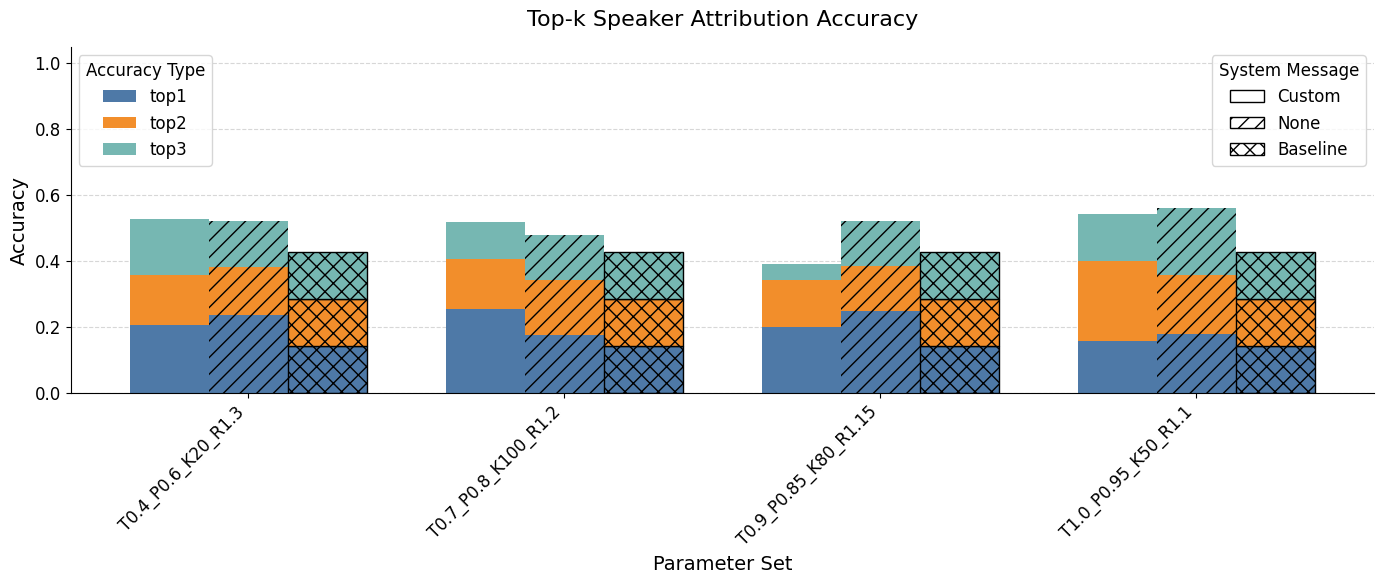

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

# Copy the original results dataframe
df = results_df.copy()
df = df.groupby(['param_set', 'conv_type']).mean().reset_index().drop(columns=['exp'])

# Add baseline rows
baseline_data = []
for ps in df["param_set"].unique():
    baseline_data.append({
        "param_set": ps,
        "conv_type": "Baseline",
        "top1": 1/7,
        "top2": 2/7,
        "top3": 3/7
    })
df = pd.concat([df, pd.DataFrame(baseline_data)], ignore_index=True)

param_sets = df["param_set"].unique()
conv_types = ["Custom", "None", "Baseline"]

x = np.arange(len(param_sets))
bar_width = 0.25

# More professional, muted color palette
colors = {"top1": "#4E79A7", "top2": "#F28E2B", "top3": "#76B7B2"}
hatches = {"Custom": "", "None": "//", "Baseline": "xx"}

# Set global font size for research paper
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(14, 6))

# Plot stacked bars with incremental heights
for j, conv in enumerate(conv_types):
    subset = df[df["conv_type"] == conv].set_index("param_set").loc[param_sets]
    x_positions = x + (j - 1) * bar_width

    bottom = np.zeros(len(param_sets))
    for metric, prev_metric in zip(["top1", "top2", "top3"], [None, "top1", "top2"]):
        if prev_metric is None:
            heights = subset[metric].values
        else:
            heights = subset[metric].values - subset[prev_metric].values  # incremental amount
        ax.bar(
            x_positions,
            heights,
            width=bar_width,
            bottom=bottom,
            color=colors[metric],
            label=metric if j == 0 else None,
            hatch=hatches[conv],
            edgecolor="black" if conv == "Baseline" else None,
        )
        bottom += heights  # increment bottom for next stack

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(param_sets, rotation=45, ha="right")
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xlabel("Parameter Set", fontsize=14)
ax.set_title("Top-k Speaker Attribution Accuracy", fontsize=16, pad=15)

# Y-axis limit for clarity
ax.set_ylim(0, 1.05)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Subtle gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

# Accuracy type legend (colors)
accuracy_patches = [Patch(facecolor=colors[m], label=m) for m in ["top1","top2","top3"]]
legend1 = ax.legend(handles=accuracy_patches, title="Accuracy Type", loc="upper left", fontsize=12, title_fontsize=12)

# System Message legend (hatches)
system_patches = [Patch(facecolor="white", hatch=hatches[g], edgecolor="black", label=g) for g in conv_types]
legend2 = ax.legend(handles=system_patches, title="System Message", loc="upper right", fontsize=12, title_fontsize=12)

# Add the first legend back
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig("SAA.png", dpi=300)
plt.show()


## Single Speaker

In [144]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt


def load_model_and_tokenizer(speaker):
    repo_id = f"smerrillunc/{speaker}_prediction"
    tokenizer = AutoTokenizer.from_pretrained(repo_id)
    model = AutoModelForSequenceClassification.from_pretrained(repo_id)
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    return model, tokenizer


def classify_batch(texts, speaker, threshold=0.1, batch_size=32):
    model, tokenizer = load_model_and_tokenizer(speaker)
    device = next(model.parameters()).device

    # ✅ Ensure list of strings
    texts = list(map(str, texts))

    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=1024, return_tensors='pt')
    dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_probs = []
    with torch.no_grad():
        for input_ids, attention_mask in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())

    all_preds = (np.array(all_probs) >= threshold).astype(int)

    return [
        {"text": txt, "probability": float(prob), "predicted_label": int(pred)}
        for txt, prob, pred in zip(texts, all_probs, all_preds)
    ]

In [145]:
import pandas as pd
df = pd.DataFrame()
conv_types = ['Custom', 'None']
exps = [3.1, 3.2, 3.3, 3.4, 3.5]
for conv_type in conv_types:
    for param_set in param_sets:
        for exp in exps:
            file_path = f'/playpen-ssd/smerrill/llm_decisions/app/results/2025-07-29/simulation_results/{conv_type}/{exp}/{param_set}/full_conversation.json'
            with open(file_path, 'r') as f:
                data = json.load(f)
                
            # filter out seed message an final message
            data = data[1:-1]
            
            tmp = pd.DataFrame(data)
            tmp['conv_type'] = conv_type    
            tmp['param_set'] = param_set
            tmp['exp'] = exp
            df = pd.concat([df, tmp], ignore_index=True)


In [146]:
output_df = pd.DataFrame()

for speaker in df.speaker.unique():
    speaker_df = df[df.speaker == speaker]
    
    for param_set in param_sets:
        for conv_type in conv_types:
            
            try:
                texts = speaker_df[(speaker_df.param_set == param_set)&(speaker_df.conv_type == conv_type)]['content'].tolist()
                results = classify_batch(texts, speaker, threshold=0.5, batch_size=32)
                results = pd.DataFrame(results)
                results['param_set'] = param_set
                results['conv_type'] = conv_type   
                results['speaker']  = speaker
                output_df = pd.concat([output_df,results], ignore_index=True)
            except:
                continue

In [154]:
final_result = []
for param_set in param_sets:
    for conv_type in conv_types:
        subset = output_df[(output_df["param_set"]==param_set) & (output_df["conv_type"]==conv_type)]
        tmp = {
            'param_set':param_set,
            'conv_type':conv_type,
            'fool_rate':subset['predicted_label'].mean()
        }
        final_result.append(tmp)
final_result = pd.DataFrame(final_result)

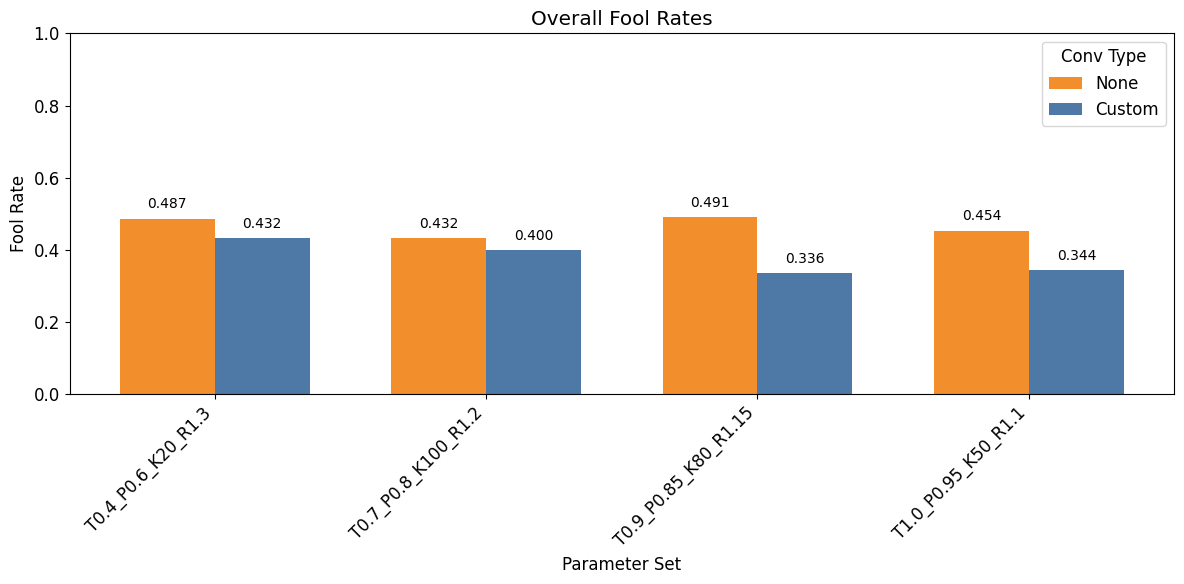

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
param_sets = final_result["param_set"].unique()
x = np.arange(len(param_sets))
bar_width = 0.35
colors = {"None": "#F28E2B", "Custom": "#4E79A7"}

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for 'None' and 'Custom'
for i, conv in enumerate(["None", "Custom"]):
    y = [final_result[(final_result["param_set"]==ps) & (final_result["conv_type"]==conv)]["fool_rate"].values[0] 
         for ps in param_sets]
    ax.bar(x + i*bar_width, y, width=bar_width, color=colors[conv], label=conv)

# X-axis labels
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(param_sets, rotation=45, ha="right")
ax.set_ylabel("Fool Rate")
ax.set_xlabel("Parameter Set")
ax.set_title("Overall Fool Rates")
ax.set_ylim(0, 1)

# Legend
ax.legend(title="Conv Type")

# Optional: add numeric values on top of bars
for i, conv in enumerate(["None", "Custom"]):
    y = [final_result[(final_result["param_set"]==ps) & (final_result["conv_type"]==conv)]["fool_rate"].values[0] 
         for ps in param_sets]
    for j, val in enumerate(y):
        ax.text(x[j] + i*bar_width, val + 0.02, f"{val:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('overall_fool.png')
plt.show()


In [149]:
final_result = []
for param_set in param_sets:
    for speaker in df.speaker.unique():
        subset = output_df[(output_df["param_set"]==param_set) & (output_df["speaker"]==speaker)]
        tmp = {
            'param_set':param_set,
            'speaker':speaker,
            'fool_rate':subset['predicted_label'].mean()
        }
        final_result.append(tmp)
final_result = pd.DataFrame(final_result)

In [150]:
final_result

,param_set,speaker,fool_rate
0,T0.4_P0.6_K20_R1.3,kateacuff,0.966102
1,T0.4_P0.6_K20_R1.3,ellenosborne,0.181818
2,T0.4_P0.6_K20_R1.3,katrinacallsen,0.789474
3,T0.4_P0.6_K20_R1.3,davidoberg,0.102564
4,T0.4_P0.6_K20_R1.3,jonnoalcaro,0.172414
5,T0.4_P0.6_K20_R1.3,judyle,0.000000
6,T0.4_P0.6_K20_R1.3,grahampaige,0.857143
7,T0.7_P0.8_K100_R1.2,kateacuff,1.000000
8,T0.7_P0.8_K100_R1.2,ellenosborne,0.187500
9,T0.7_P0.8_K100_R1.2,katrinacallsen,0.750000


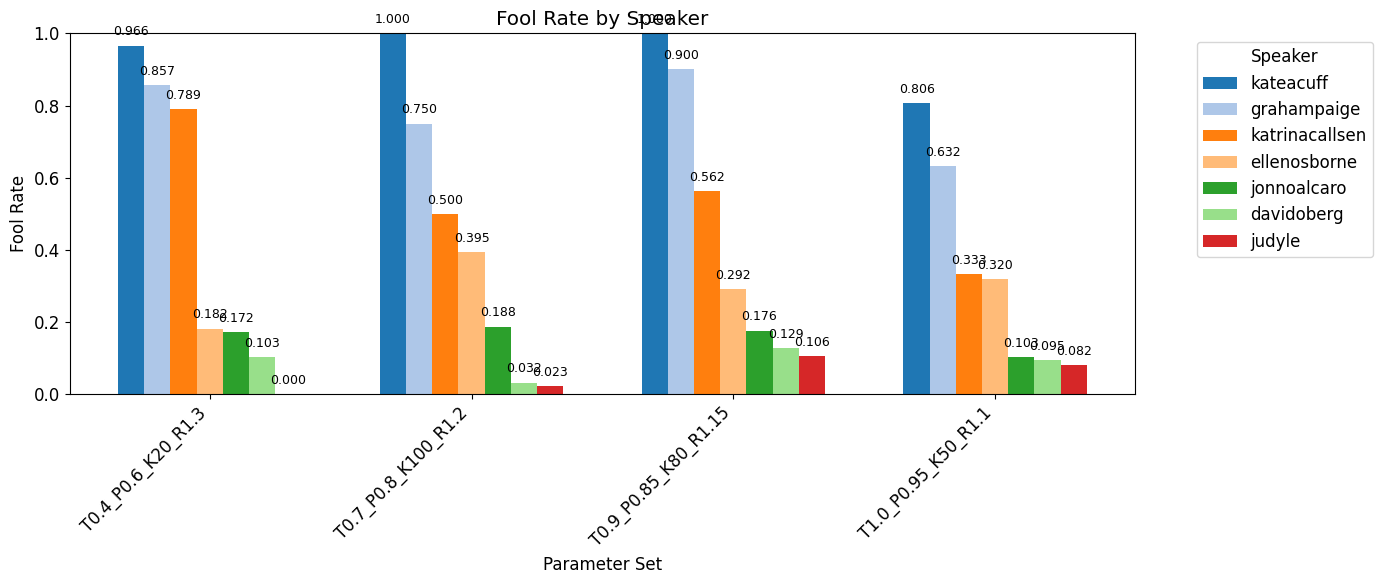

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# Assume your dataframe is called final_result_speakers
param_sets = final_result["param_set"].unique()

x = np.arange(len(param_sets))  # positions for each param_set
bar_width = 0.1

# Color palette for speakers
speakers = final_result["speaker"].unique()
colors = plt.cm.tab20.colors

fig, ax = plt.subplots(figsize=(14, 6))

# Plot bars for each param_set
for j, ps in enumerate(param_sets):
    # Get data for this param_set and sort by fool_rate descending
    subset = final_result[final_result["param_set"]==ps].sort_values("fool_rate", ascending=False)
    
    for i, (idx, row) in enumerate(subset.iterrows()):
        ax.bar(x[j] + i*bar_width, row["fool_rate"], width=bar_width,
               color=colors[i % len(colors)], label=row["speaker"] if j==0 else "")

# X-axis labels
ax.set_xticks(x + bar_width*(len(speakers)-1)/2)
ax.set_xticklabels(param_sets, rotation=45, ha="right")
ax.set_ylabel("Fool Rate")
ax.set_xlabel("Parameter Set")
ax.set_title("Fool Rate by Speaker")

ax.set_ylim(0, 1)

# Legend
ax.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add values on top of bars
for j, ps in enumerate(param_sets):
    subset = final_result[final_result["param_set"]==ps].sort_values("fool_rate", ascending=False)
    for i, (idx, row) in enumerate(subset.iterrows()):
        ax.text(x[j] + i*bar_width, row["fool_rate"] + 0.02, f"{row['fool_rate']:.3f}",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('agent_fool.png')
plt.show()
